In [4]:
# we are Traing 100 model which model work proper i will take that

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBRegressor

In [6]:
df = pd.read_csv('/content/sample_data/gurgaon_properties_post_feature_selection_v2.csv')

# we change this all encoding things inside pipe lines

In [29]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [8]:
df['furnishing_type'].value_counts()

,count
furnishing_type,
0.0,2349
1.0,1018
2.0,187


In [9]:
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [10]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [11]:
X = df.drop(columns=['price'])
y = df['price']

In [12]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

Ordinal Encoding

1) Ordinal Encoding (tree base)
2) One Hot Encoding (linear base)
3) Target Encoding (high dimension features)

i will go with all and then i find r2 score

In [13]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [14]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ],
    remainder='passthrough'
)

In [15]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [16]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [17]:
scores.mean(),scores.std()

(np.float64(0.7363096633436828), np.float64(0.03238005754429932))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [19]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [20]:
y_pred = pipeline.predict(X_test)

In [21]:
y_pred = np.expm1(y_pred)

In [22]:
mean_absolute_error(np.expm1(y_test),y_pred)
# 94 lakh different

0.946382216008936

now covert this whole process in the function

In [23]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [24]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(), # multilayer perseptron
    'xgboost':XGBRegressor()
}

In [25]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [26]:
model_output

[['linear_reg', np.float64(0.7363096633436828), 0.946382216008936],
 ['svr', np.float64(0.7642021216646014), 0.8472636473483917],
 ['ridge', np.float64(0.7363125343993554), 0.9463387741853388],
 ['LASSO', np.float64(0.05943378064493573), 1.528905986892753],
 ['decision tree', np.float64(0.7749655438603466), 0.7313361832425497],
 ['random forest', np.float64(0.8810227593973285), 0.5322809578107733],
 ['extra trees', np.float64(0.8673138761835926), 0.5564744316340176],
 ['gradient boosting', np.float64(0.8725568845854303), 0.5752038017321395],
 ['adaboost', np.float64(0.7547400082988529), 0.8419579155650069],
 ['mlp', np.float64(0.8101122878940746), 0.7224621520399821],
 ['xgboost', np.float64(0.8894876835260124), 0.5040475127230885]]

In [27]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [28]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.881023,0.532281
6,extra trees,0.867314,0.556474
7,gradient boosting,0.872557,0.575204
9,mlp,0.810112,0.722462
4,decision tree,0.774966,0.731336
8,adaboost,0.754740,0.841958
1,svr,0.764202,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382


At the time of ordinal encoding we get best ouput at DT models

# onehotencoding

In [30]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ],
    remainder='passthrough'
)
# catogorical columns have multiple catorory ex-50 so dimensinality will increase (training slow,overfiting)
# linnera model performence was improved
# MAE : reduced
# you can use PCA to remove dimenstion

In [31]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [32]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [33]:
scores.mean()

np.float64(0.06225201431451134)

In [34]:
scores.std()

np.float64(0.019860594071640165)

In [35]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [36]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [37]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [38]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [39]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.762014,0.647744
6,extra trees,0.739377,0.697181
4,decision tree,0.696442,0.761509
10,xgboost,0.622205,0.967581
7,gradient boosting,0.610623,0.987906
1,svr,0.218073,1.361198
8,adaboost,0.312746,1.385685
9,mlp,0.214063,1.409282
2,ridge,0.062252,1.526707
0,linear_reg,0.062252,1.526707


# Target Encoder

PCA :- 95% explain varibale give very bad result

In [43]:
!pip install category_encoders

import category_encoders as ce

columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.2 MB/s eta 0:00:00


In [44]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [45]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [46]:
scores.mean(),scores.std()

(np.float64(0.829521918225536), np.float64(0.018384463379122903))

In [47]:
def scorer(model_name, model):

    output = []

    output.append(model_name)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output

In [48]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [49]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [50]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [51]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.904798,0.447518
5,random forest,0.902108,0.452250
6,extra trees,0.901626,0.459290
7,gradient boosting,0.888861,0.509344
4,decision tree,0.826878,0.542140
9,mlp,0.844450,0.649785
8,adaboost,0.813710,0.680177
0,linear_reg,0.829522,0.713011
2,ridge,0.829536,0.713523
1,svr,0.782917,0.818851


# Hyperparameter Tuning

**target encoding**: high dimension column


In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [55]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

In [56]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [57]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [58]:
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [ ]:
search.fit(X, y_transformed)

In [ ]:
final_pipe = search.best_estimator_

In [ ]:
search.best_params_

In [ ]:
search.best_score_

In [ ]:
final_pipe.fit(X,y_transformed)

XGboost + Bayersion (hyperopx -> (hyper parameter))
very good

ex - 0.90 MSE - 0.45

to

0.92 MSE - 0.44

(it will test by kagal compitation)

Now We are using Random Forest with default setting

# Exporting the model

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ],
    remainder='passthrough'
)

In [63]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [64]:
pipeline.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sector',
                                                   'agePossession'])])),
                ('regressor', RandomForestRegressor(n_estimators=500))])

In [65]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [66]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

we make a file which have pipeline for each encoding and save it becase i will use it again

all fearther i will use for website devlopment

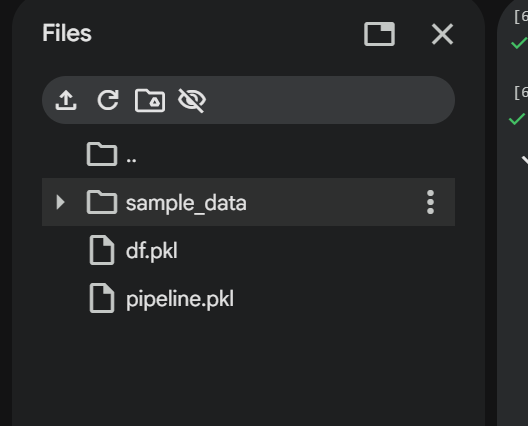



In [67]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3549,flat,sector 84,2.0,2.0,1,Relatively New,532.0,0.0,0.0,unfurnished,Medium,Mid Floor
3550,house,sector 109,5.0,5.0,3+,Relatively New,6228.0,1.0,1.0,unfurnished,High,Low Floor
3551,flat,sector 2,1.0,1.0,1,Moderately Old,665.0,0.0,0.0,semifurnished,Medium,Mid Floor
3552,house,sector 43,5.0,6.0,3,Moderately Old,5490.0,1.0,1.0,unfurnished,Medium,Mid Floor


How To reduce MAR

-> To much data

-> Hyperparameter Tuning (Xgboost)

-> Revisite All The Steps

# Trying out the predictions

In [68]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [69]:
X.iloc[0].values

array(['flat', 'sector 36', np.float64(3.0), np.float64(2.0), '2',
       'New Property', np.float64(850.0), np.float64(0.0),
       np.float64(0.0), 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [97]:
data = [['house', 'sector 4', 4, 3, '3+', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 4,4,3,3+,New Property,2750,0,0,unfurnished,Low,Low Floor


In [98]:
np.expm1(pipeline.predict(one_df))
# 47 lack of error so it will in both direction +-

array([5.20761544])

In [72]:
X.dtypes

,0
property_type,object
sector,object
bedRoom,float64
bathroom,float64
balcony,object
agePossession,object
built_up_area,float64
servant room,float64
store room,float64
furnishing_type,object


In [73]:
sorted(X['sector'].unique().tolist())

['dwarka expressway',
 'gwal pahari',
 'manesar',
 'sector 1',
 'sector 10',
 'sector 102',
 'sector 103',
 'sector 104',
 'sector 105',
 'sector 106',
 'sector 107',
 'sector 108',
 'sector 109',
 'sector 11',
 'sector 110',
 'sector 111',
 'sector 112',
 'sector 113',
 'sector 12',
 'sector 13',
 'sector 14',
 'sector 15',
 'sector 17',
 'sector 2',
 'sector 21',
 'sector 22',
 'sector 23',
 'sector 24',
 'sector 25',
 'sector 26',
 'sector 27',
 'sector 28',
 'sector 3',
 'sector 30',
 'sector 31',
 'sector 33',
 'sector 36',
 'sector 37',
 'sector 37d',
 'sector 38',
 'sector 39',
 'sector 4',
 'sector 40',
 'sector 41',
 'sector 43',
 'sector 45',
 'sector 46',
 'sector 47',
 'sector 48',
 'sector 49',
 'sector 5',
 'sector 50',
 'sector 51',
 'sector 52',
 'sector 53',
 'sector 54',
 'sector 55',
 'sector 56',
 'sector 57',
 'sector 58',
 'sector 59',
 'sector 6',
 'sector 60',
 'sector 61',
 'sector 62',
 'sector 63',
 'sector 63a',
 'sector 65',
 'sector 66',
 'sector 67',
 'se